# My first Notebook - ice or ship?

In [1]:
%matplotlib inline


## Introduction

In this notebook, i will try to implacate the first and secoend lesson of fast.ai.
i decide to try join the competetion "Statoil/C-CORE Iceberg Classifier Challenge".
the plan is:
1. load the vgg-16 model
2. pre-train the model to fit the classifiction.

thing that i need to learn (that i know in the begeining):
1. handel json file
2. there is 2 layer in our data, and 3 layer in vgg model.
3. how to use the angle information.
4. make my own image classification :)

let's start!

In [2]:
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
import skimage
from skimage import transform

In [4]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '11004' (I am process '4024')
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmpxh4jdj/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmpxh4jdj/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN 5005)


In [5]:
#i download the date to this path:
path = "shipvsice/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

just to summerise: in the train.json file we have this parameter:
        1. id
        2. band_1 band_2
        3. inc_angle - the angle of witch the image was taken (if missing - "na") 
        4. is_iceberg - 1 to yes, 0 to ship.
        
maybe we can do some good with the angle, but because i **mainly** focus in computer vision, i decide to ignore it.

In [6]:
# load and the data quick
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [7]:
#and now we load the data
X_train = load_array(path+'train_data3.bc')
X_test = load_array(path+'X_test.bc')
X_target_train = load_array(path+'target_train.bc')

In [9]:
train = pd.read_json(path+'train.json')
test = pd.read_json(path+'test.json')
target_train = train['is_iceberg']

In [8]:
import cv2 #this makes OpenCV available
from cv2 import *
from scipy.misc import toimage

we have **two** type of layer. so, i created a new layer who its the two layer multiplication.
i did it because i think that in this way the diffrent between high param and small will be more concrit.

i addition, i normalize all the layer to 0-1.

In [12]:
##secoend - the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_1 = cv2.normalize(X_band_1, X_band_1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_2 = cv2.normalize(X_band_2, X_band_2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
X_band_3=np.multiply(X_band_1,X_band_2)
X_band_3 = cv2.normalize(X_band_3, X_band_3, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
X_train_re = np.concatenate([X_band_1[:, :, :, np.newaxis]
                         , X_band_2[:, :, :, np.newaxis]
                        , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [13]:
save_array(path+'train_data3.bc', X_train)
save_array(path+'X_test.bc', X_test)
save_array(path+'target_train.bc', target_train)

now i want to cut the intresting part of the image.
we know that the highest point is probably the intresting center. so we create 12 * 12 around that.
i use OpenCV to create it.

In [9]:
temp2 = np.zeros((1604,12,12,3),dtype=np.float)

for i in range(1604):
    temp=X_train[i,:,:,2].argmax()
    axis_2 = temp%75
    if(axis_2>68):
        axis_2 -= 5
    if(axis_2<4):
        axis_2 += 7
    axis_1 = int((temp-axis_2)/75)
    if(axis_1>67):
        axis_2 -= 5
    if(axis_1<5):
        axis_2 += 7
    
    for j in range(3):
        for k in range(12):
            for l in range(12):
                if(axis_1-5+k > 74 or axis_2 - 5 + l> 74 or axis_1-5+k < 0 or axis_2 - 5 + l < 0):
                    temp2[i,l,k,j] = 0
                else:
                    temp2[i,k,l,j]= X_train[i,axis_1-5+k,axis_2 - 5 + l,j]

## visual the data
i want to show 2 image, so we can have a clue about the image we dealing with

In [10]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


C:\Users\hanan\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['divide', 'random', 'bitwise_or', 'repeat', 'bitwise_and', 'imread', 'bitwise_xor', 'randn', 'log', 'invert', 'imshow', 'sqrt', 'add', 'split', 'norm', 'sort', 'trace', 'transpose', 'resize', 'multiply', 'subtract', 'bitwise_not', 'flip', 'solve', 'exp', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
a = temp2[2] #ice
b = temp2[3] #ship

<IPython.core.display.Javascript object>


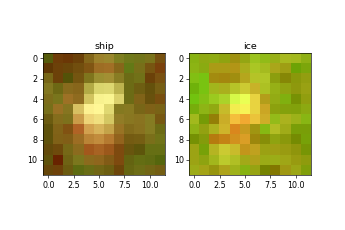

Text(0.5,1,u'ice')

In [12]:
subplot(1,2,1)
imshow(toimage(b))
title('ship')
subplot(1,2,2)
imshow(toimage(a))
title('ice')

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
    data = [go.Surface(z=c)]
    layout = go.Layout(title=name,autosize=False,width=700,height=700,margin=dict(l=65,r=50,b=65,t=90))
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [16]:
plotmy3d(a[:,:,0], 'ice')

In [17]:
plotmy3d(b[:,:,0], 'ship')

You can see that the ship is a bit smoother than the iceberg.

## Preparing data for learning

beacse we dont have validion set, we spilt the data:

In [18]:
train = temp2[431:1604]
valid = temp2[0:430]
train_label = X_target_train[431:1604]
valid_label = X_target_train[0:430]

In [19]:
gen = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.5, 
       height_shift_range=0.05, shear_range=0.05, zoom_range=0.01, 
       channel_shift_range=3, horizontal_flip=True, dim_ordering='tf')

In [20]:
def get_batches(x, y, gen=gen, shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(75,75)):
    return gen.flow(x, y , shuffle=shuffle, batch_size=batch_size)

we want that instan of (1) or (0), the label be (0 1) or (1 0):

In [21]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

trn_labels = onehot(train_label)
val_labels = onehot(valid_label)

In [22]:
K.set_image_dim_ordering('tf')

In [23]:
trn_batches = get_batches(train,train_label , shuffle=True, batch_size=16)
val_batches = get_batches(valid,valid_label , shuffle=True, batch_size=16)

# create my model

In [24]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [31]:
def getModel():   
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
#     gmodel.add(BatchNormalization(axis=1, input_shape=(75, 75,3)))
    gmodel.add(Convolution2D(32, 3, 3, activation='relu',input_shape=(12, 12,3)))
    gmodel.add(ZeroPadding2D(padding=(1, 1)))
    gmodel.add(BatchNormalization(axis=1))
    gmodel.add(Convolution2D(32, 3, 3, activation='relu'))
    gmodel.add(ZeroPadding2D(padding=(1, 1)))
    gmodel.add(BatchNormalization(axis=1))
    gmodel.add(Convolution2D(16, 3, 3, activation='relu'))

    #Dense Layers
    gmodel.add(Flatten())
    gmodel.add(BatchNormalization(axis=1))
    gmodel.add(Dense(1024))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.3))

    #Dense Layer 2
    gmodel.add(BatchNormalization(axis=1))
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.1))

    #Sigmoid Layer
    gmodel.add(BatchNormalization(axis=1))
    gmodel.add(Dense(2))
    gmodel.add(Activation('sigmoid'))

    gmodel.summary()
    return gmodel

  

In [32]:
import os
gmodel=getModel()

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 10, 10, 32)    896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 12, 12, 32)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 12, 12, 32)    48          zeropadding2d_3[0][0]            
___________________________________________________________________________________________________

In [33]:
gmodel.load_weights('final.h5')

In [34]:
optim = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
gmodel.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
gmodel.fit(train, trn_labels, batch_size=32, nb_epoch=20, validation_data=(valid,val_labels))

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmppdj12d/6f9c33a9f3c62d241d643cb3ab7c1393.lib and object C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmppdj12d/6f9c33a9f3c62d241d643cb3ab7c1393.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmpzrxbew/0e8d45aa8335bbc9b7477411a05bc380.lib and object C:/Users/hanan/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-2.7.14-64/tmpzrxbew/0e8d45aa8335bbc9b7477411a05bc380.exp



Train on 1173 samples, validate on 430 samples
Epoch 1/20
1173/1173 [==============================] - 2s - loss: 0.1133 - acc: 0.9420 - val_loss: 0.3969 - val_acc: 0.8558
Epoch 2/20
1173/1173 [==============================] - 2s - loss: 0.0975 - acc: 0.9565 - val_loss: 0.3921 - val_acc: 0.8488
Epoch 3/20
1173/1173 [==============================] - 2s - loss: 0.1081 - acc: 0.9540 - val_loss: 0.3953 - val_acc: 0.8535
Epoch 4/20
1173/1173 [==============================] - 2s - loss: 0.1003 - acc: 0.9514 - val_loss: 0.3930 - val_acc: 0.8535
Epoch 5/20
1173/1173 [==============================] - 2s - loss: 0.0991 - acc: 0.9557 - val_loss: 0.3974 - val_acc: 0.8535
Epoch 6/20
1173/1173 [==============================] - 2s - loss: 0.0986 - acc: 0.9514 - val_loss: 0.4095 - val_acc: 0.8535
Epoch 7/20
1173/1173 [==============================] - 2s - loss: 0.1123 - acc: 0.9480 - val_loss: 0.3902 - val_acc: 0.8512
Epoch 8/20
1173/1173 [==============================] - 2s - loss: 0.0955 - ac

In [35]:
gmodel.save_weights('final.h5')

In [36]:
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

1173/1173 [==============================] - ETA:  - 1s     


<IPython.core.display.Javascript object>


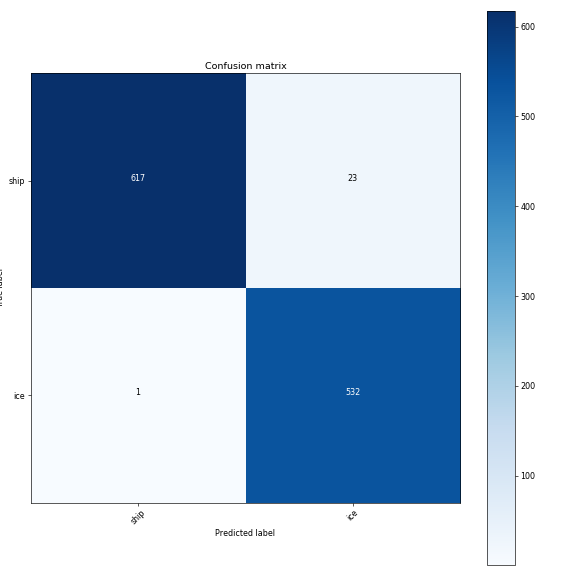

[[617  23]
 [  1 532]]


In [37]:
preds_test = gmodel.predict_classes(train, batch_size=16)
cm = confusion_matrix(train_label, preds_test)
plot_confusion_matrix(cm, ('ship','ice'))

430/430 [==============================] - 0s     


<IPython.core.display.Javascript object>


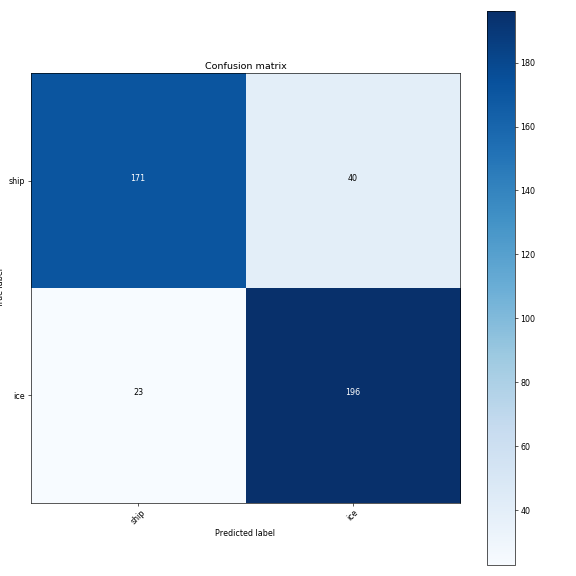

[[171  40]
 [ 23 196]]


In [38]:
preds_valid = gmodel.predict_classes(valid, batch_size=16)
cm = confusion_matrix(valid_label, preds_valid)
plot_confusion_matrix(cm, ('ship','ice'))